In [23]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib
import imgaug.augmenters as iaa
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras_unet.models import custom_unet
from keras_unet.metrics import iou
from keras_unet.losses import jaccard_distance
from skimage import morphology
from sklearn.model_selection import train_test_split

In [24]:
tf.__version__

'2.3.1'

# Data preparation

In [25]:
CXR_TRAIN_IMAGE_BASE_PATH = '/home/daniel/dev/python/chest_x_ray/data/lung_segmentation/CXR_png'
CXR_TRAIN_MASKS_BASE_PATH = '/home/daniel/dev/python/chest_x_ray/data/lung_segmentation/masks'
MODEL_CHECKPOINT_PATH = '/home/daniel/dev/python/chest_x_ray/models/unet_grayscaled_0401.h5'
np.random.seed(10)

In [26]:
CXR_TRAIN_IMAGE_BASE_PATH = '/home/8cb7/kaggle_data/lung_segmentation/CXR_png/'
CXR_TRAIN_MASKS_BASE_PATH = '/home/8cb7/kaggle_data/lung_segmentation/masks/'
MODEL_CHECKPOINT_PATH = '/home/8cb7/kaggle_data/models/unet_grayscaled_0401.h5'

In [27]:
def load_images():
    images = sorted(list(Path(os.path.join(CXR_TRAIN_IMAGE_BASE_PATH)).glob('**/*')))
    masks = sorted(list(Path(os.path.join(CXR_TRAIN_MASKS_BASE_PATH)).glob('**/*')))
    print("Amount of images: ", len(images))
    print("Amount of masks: ", len(masks))
    return images, masks

def generate_tuple(images, masks):
    img_mask_tuples = []
    for mask_path in masks:
        for i in images:
            basename = (os.path.basename(i)).split(".")[0]
            if basename in str(mask_path):
                img_path = i
                break
        img_mask_tuples.append((str(img_path), str(mask_path)))
    print("Amount of tuples: ", len(img_mask_tuples))
    return img_mask_tuples


In [28]:
images, masks = load_images()
img_mask_tuples = generate_tuple(images, masks)
len(img_mask_tuples)

Amount of images:  800
Amount of masks:  704
Amount of tuples:  704


704

## Plot images and masks

In [29]:
def plot_img(img_mask_tuple):
    img_concat = np.concatenate((cv2.imread(str(img_mask_tuple[0])), cv2.imread(str(img_mask_tuple[1]))), axis=1)
    plt.axis('off')
    plt.imshow(img_concat)

In [30]:
# plot_img(img_mask_tuples[3])

In [31]:
def plot_img_matrix(img_mask_tuple_list, cols):
    # concat
    images = []
    for t in img_mask_tuple_list:
        img_concat = np.concatenate((cv2.imread(str(t[0])), cv2.imread(str(t[1]))), axis=1)
        images.append(img_concat)
    # plot
    plt.subplots(figsize=(15,5))
    if len(images) % cols == 0:
        rows = len(images) / cols
    else:
        rows = (len(images) % cols) +1
    for num, x in enumerate(images):
        plt.subplot(rows,cols,num+1)
        plt.axis('off')
        plt.imshow(x)

In [32]:
# plot_img_matrix(img_mask_tuples[:10], 4)

In [33]:
df = pd.DataFrame(img_mask_tuples, dtype='str', columns=['img', 'mask'])

df_train, df_test = train_test_split(df, test_size=0.4)
df_test, df_val = train_test_split(df_test, test_size=0.5)


df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)


print("# train ", len(df_train))
print("# test  ", len(df_test))
print("# val   ", len(df_val))

# train  422
# test   141
# val    141


## UNET

In [34]:
IMG_SIZE = 256
BATCH_SIZE = 8
DILATE_KERNEL = np.ones((15, 15), np.uint8)

In [35]:
# sometimes = lambda aug: iaa.Sometimes(0.5, aug)
# seq_img = iaa.Sequential([
#     #iaa.Fliplr(0.5),
#     aug_clahe,
# #     sometimes(iaa.Affine(
# #            rotate=(-10, 10),
# #            shear=(10,10),
# #             scale={"x": (1, 1.1), "y": (1, 1.1)},
# #     )),
# ], random_order=True)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, shuffle=True, augment=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X_img, X_mask = self.__get_data(batch)
        return np.array(X_img), np.array(X_mask)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)    

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        
        X_imgs = []
        X_masks = []

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            img = img.reshape(img.shape[0], img.shape[1], 1)
            
            mask = cv2.resize(cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE) ,interpolation=cv2.INTER_NEAREST)
            
            # 1 dialete
            # dialete to get more information at the lunge edges
            mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
            mask = cv2.threshold(mask_dilate,127,255,cv2.THRESH_BINARY)[1]
            
            # 2 clahe
            img_norm = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
#             clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(4,4))
            # clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(4,4))
#             img = clahe.apply(img_norm)
                    
            # normalize / rescale
            img = img / 255
            mask = mask / 255

            X_imgs.append(img)
            X_masks.append(mask)

        return X_imgs, X_masks

In [36]:
train_generator = DataGenerator(df_train,shuffle=True, augment=False)
val_generator = DataGenerator(df_val, shuffle=False, augment=False)

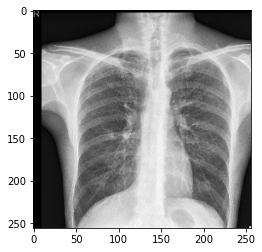

In [37]:
example = train_generator.__getitem__(0)
example[0].shape
plt.imshow(example[0][-1,:,:], cmap="gray")

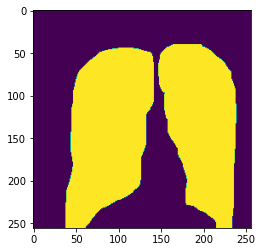

In [38]:
plt.imshow(example[1][-1,:,:])

In [39]:
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coeff(y_true, y_pred)

def dice_be(y_true, y_pred):
    dl = dice_loss(y_true, y_pred)
    bce = K.binary_crossentropy(y_true, y_pred)
    return 2.0 * dl + 1.0 * bce

In [40]:
recall = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)

In [41]:
model = custom_unet(
    input_shape=(256, 256, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=2e-4),
    # loss=dice_loss,
    loss='binary_crossentropy',
    # loss=dice_coef_loss,
    metrics=['binary_accuracy', iou, recall]
)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d_5 (SpatialDro (None, 256, 256, 64) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       spatial_dropout2d_5[0][0]        
_______________________________________________________________________________________

In [42]:
mcp_save = ModelCheckpoint(MODEL_CHECKPOINT_PATH, save_best_only=True, monitor='val_iou', mode='max')
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1, verbose=1)

In [43]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[reduceLROnPlat])

Epoch 1/20
53/53 [==============================] - 62s 1s/step - loss: 0.6028 - binary_accuracy: 0.6828 - iou: 0.2954 - recall_1: 0.3692 - val_loss: 0.4551 - val_binary_accuracy: 0.7991 - val_iou: 0.3941 - val_recall_1: 0.8040
Epoch 2/20
53/53 [==============================] - 60s 1s/step - loss: 0.3897 - binary_accuracy: 0.8177 - iou: 0.4832 - recall_1: 0.7449 - val_loss: 0.3342 - val_binary_accuracy: 0.8448 - val_iou: 0.4926 - val_recall_1: 0.5891
Epoch 3/20
53/53 [==============================] - 60s 1s/step - loss: 0.2897 - binary_accuracy: 0.8691 - iou: 0.6019 - recall_1: 0.7586 - val_loss: 0.2155 - val_binary_accuracy: 0.9154 - val_iou: 0.6726 - val_recall_1: 0.8528
Epoch 4/20
53/53 [==============================] - 60s 1s/step - loss: 0.1847 - binary_accuracy: 0.9249 - iou: 0.7409 - recall_1: 0.8858 - val_loss: 0.1418 - val_binary_accuracy: 0.9448 - val_iou: 0.7710 - val_recall_1: 0.9225
Epoch 5/20
53/53 [==============================] - 60s 1s/step - loss: 0.1414 - binary_

In [26]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[reduceLROnPlat])

Epoch 1/20
52/52 [==============================] - 59s 1s/step - loss: 0.5539 - binary_accuracy: 0.7193 - iou: 0.3314 - val_loss: 0.4290 - val_binary_accuracy: 0.7905 - val_iou: 0.5059
Epoch 2/20
52/52 [==============================] - 60s 1s/step - loss: 0.3471 - binary_accuracy: 0.8393 - iou: 0.5345 - val_loss: 0.2976 - val_binary_accuracy: 0.8584 - val_iou: 0.5445
Epoch 3/20
52/52 [==============================] - 60s 1s/step - loss: 0.2487 - binary_accuracy: 0.8904 - iou: 0.6535 - val_loss: 0.1718 - val_binary_accuracy: 0.9352 - val_iou: 0.7295
Epoch 4/20
52/52 [==============================] - 59s 1s/step - loss: 0.1707 - binary_accuracy: 0.9317 - iou: 0.7602 - val_loss: 0.1386 - val_binary_accuracy: 0.9458 - val_iou: 0.7758
Epoch 5/20
52/52 [==============================] - 60s 1s/step - loss: 0.1317 - binary_accuracy: 0.9478 - iou: 0.8110 - val_loss: 0.1095 - val_binary_accuracy: 0.9570 - val_iou: 0.8409
Epoch 6/20
52/52 [==============================] - 59s 1s/step - loss

KeyboardInterrupt: 

In [190]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[reduceLROnPlat])

Epoch 1/20
70/70 [==============================] - 69s 979ms/step - loss: 0.4481 - binary_accuracy: 0.7874 - iou: 0.2526 - val_loss: 0.2628 - val_binary_accuracy: 0.9084 - val_iou: 0.4009
Epoch 2/20
70/70 [==============================] - 68s 969ms/step - loss: 0.2176 - binary_accuracy: 0.9128 - iou: 0.5870 - val_loss: 0.1235 - val_binary_accuracy: 0.9523 - val_iou: 0.7460
Epoch 3/20
70/70 [==============================] - 68s 972ms/step - loss: 0.1157 - binary_accuracy: 0.9562 - iou: 0.7703 - val_loss: 0.1033 - val_binary_accuracy: 0.9607 - val_iou: 0.7790
Epoch 4/20
70/70 [==============================] - 68s 976ms/step - loss: 0.0995 - binary_accuracy: 0.9620 - iou: 0.7981 - val_loss: 0.0859 - val_binary_accuracy: 0.9677 - val_iou: 0.8076
Epoch 5/20
70/70 [==============================] - 69s 979ms/step - loss: 0.0871 - binary_accuracy: 0.9669 - iou: 0.8211 - val_loss: 0.0767 - val_binary_accuracy: 0.9723 - val_iou: 0.8119
Epoch 6/20
70/70 [==============================] - 68s

In [63]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[mcp_save, reduceLROnPlat])

Epoch 1/20
70/70 [==============================] - 69s 989ms/step - loss: 0.5944 - binary_accuracy: 0.6835 - iou: 0.2935 - val_loss: 0.4083 - val_binary_accuracy: 0.8010 - val_iou: 0.4473
Epoch 2/20
70/70 [==============================] - 69s 979ms/step - loss: 0.3063 - binary_accuracy: 0.8621 - iou: 0.5813 - val_loss: 0.2214 - val_binary_accuracy: 0.9097 - val_iou: 0.6889
Epoch 3/20
70/70 [==============================] - 68s 978ms/step - loss: 0.1690 - binary_accuracy: 0.9327 - iou: 0.7603 - val_loss: 0.1342 - val_binary_accuracy: 0.9455 - val_iou: 0.8107
Epoch 4/20
70/70 [==============================] - 68s 978ms/step - loss: 0.1365 - binary_accuracy: 0.9464 - iou: 0.8061 - val_loss: 0.1195 - val_binary_accuracy: 0.9528 - val_iou: 0.8188
Epoch 5/20
70/70 [==============================] - 67s 960ms/step - loss: 0.1075 - binary_accuracy: 0.9574 - iou: 0.8424 - val_loss: 0.1165 - val_binary_accuracy: 0.9534 - val_iou: 0.8182
Epoch 6/20
70/70 [==============================] - 68s

In [64]:
# model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH, compile=False)

## Test

In [234]:
test_generator = DataGenerator(df_test, shuffle=False, augment=False)

In [235]:
test_predictions = model.predict(test_generator, verbose=1)

13/13 [==============================] - 11s 877ms/step


In [236]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [237]:
test_predictions_t = (test_predictions > 0.5).astype('float32')  # use float32 insteaf of uint8 i.o. to get keras_unet.metrics.iou to work which uses K.sum..

In [238]:
def multiple_gt(img, mask):
    img = cv2.resize(cv2.imread(str(img), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(str(mask), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))

    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    mask = cv2.threshold(mask_dilate,127,255,cv2.THRESH_BINARY)[1]

    tmp = img * mask

    ground_t = (tmp > 0.5).astype('float32')
    return ground_t

In [239]:
import keras_unet.metrics
iou_scores=[]
for i in range(len(df_test) - 1):
    gt = multiple_gt(df_test.iloc[i][0], df_test.iloc[i][1])
    iou_scores.append(keras_unet.metrics.iou(np.squeeze(gt), np.squeeze(test_predictions_t[i])).numpy()) # need numpy so that we dont store a tensor

print('Average Test IOU: ', round(np.mean(iou_scores),2))

Average Test IOU:  0.94


## Predict and save masks

>  Important

- Please adjust the base paths BASE_MOONEY_DATA_PATH and BASE_COVID_DATA_PATH + BASE_COVID_MASKS_PATH.
- Please make sure BASE_MOONEY_DATA_PATH + /masks exists. Furthermore the test/train/val folders are required with NORMAL and PNEUMONIA as subfolders.

In [44]:
# currently not in use
def remove_small_regions(img):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    cleaned = morphology.remove_small_objects(img, min_size=64, connectivity=1)
    cleaned = morphology.remove_small_holes(img, area_threshold=64)
    return cleaned

In [45]:
def get_pred_generator(img_list):
    df = pd.DataFrame(img_list, dtype='str', columns=['img'])
    return ImageDataGenerator().flow_from_dataframe(
        dataframe=df,
        x_col='img',
        directory=None,
        target_size=(IMG_SIZE, IMG_SIZE),
        # preprocess_function=remove_small_regions,
        class_mode=None,
        color_mode='grayscale',
        batch_size=8,
    )

In [46]:
def pred_and_save_masks(in_path, out_path):
    images = list(Path(os.path.join(in_path)).glob('**/*'))
    pred = model.predict(get_pred_generator(images), batch_size=8)

    # now save our pred as images
    for i in range(0,len(pred)):
        org_img = str(images[i])
        pred_mask_name = os.path.basename(org_img).rsplit('.')[0] + '_predmask.jpg'

        mask = pred[i][:,:,0].astype(np.uint8)
        frame = mask.copy()
#         # ----- BEGIN: draw rectangle around mask -----
#         contours, hierarchy = cv2.findContours(mask.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

#         try: hierarchy = hierarchy[0]
#         except: hierarchy = []

#         height, width = mask.shape
#         min_x, min_y = width, height
#         max_x = max_y = 0

#         # computes the bounding box for the contour, and draws it on the frame,
#         for contour, hier in zip(contours, hierarchy):
#             (x,y,w,h) = cv2.boundingRect(contour)
#             min_x, max_x = min(x, min_x), max(x+w, max_x)
#             min_y, max_y = min(y, min_y), max(y+h, max_y)
#         #     if w > 80 and h > 80:
#         #         frame = cv2.rectangle(frame.copy(), (x,y), (x+w,y+h), (255, 0, 0), 2)

#         if max_x - min_x > 0 and max_y - min_y > 0:
#             frame = cv2.rectangle(frame.copy(), (min_x, min_y), (max_x, max_y), (1), cv2.FILLED)

#         # ----- END: draw rectangle around mask -----    
        
        
        plt.imshow(frame[:,:])
        plt.imsave(out_path + pred_mask_name, frame[:,:])

In [47]:
BASE_MOONEY_DATA_PATH = '/home/daniel/dev/python/chest_x_ray/data/mooney'
BASE_COVID_DATA_PATH = '/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output'
BASE_COVID_MASKS_PATH = '/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/'

In [48]:
BASE_MOONEY_DATA_PATH = '/home/8cb7/.kaggle/mooney/chest_xray'
BASE_COVID_DATA_PATH = '/home/8cb7/.kaggle/covid-chestxray-dataset/output'
BASE_COVID_MASKS_PATH = '/home/8cb7/.kaggle/covid-chestxray-dataset/masks/'

Generate masks for mooney --> test
Found 234 validated image filenames.


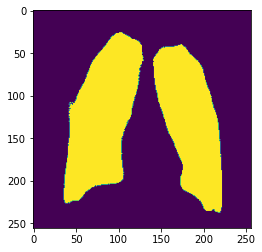

In [49]:
print("Generate masks for mooney --> test")
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/test/NORMAL/', BASE_MOONEY_DATA_PATH + '/masks/test/NORMAL/')

Found 390 validated image filenames.


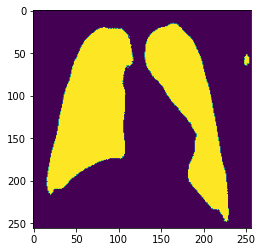

In [50]:
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/test/PNEUMONIA/', BASE_MOONEY_DATA_PATH + '/masks/test/PNEUMONIA/')

Generate masks for mooney --> train
Found 1341 validated image filenames.


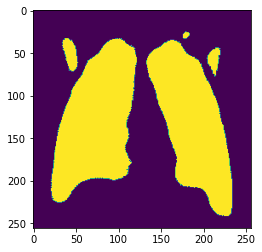

In [51]:
print("Generate masks for mooney --> train")
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/train/NORMAL/', BASE_MOONEY_DATA_PATH + '/masks/train/NORMAL/')

Found 3875 validated image filenames.


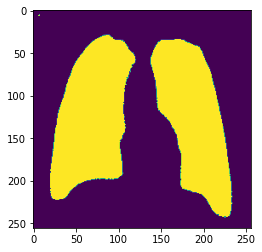

In [52]:
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/train/PNEUMONIA/', BASE_MOONEY_DATA_PATH + '/masks/train/PNEUMONIA/')

Generate masks for mooney --> val
Found 8 validated image filenames.
Found 8 validated image filenames.


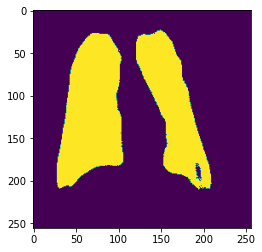

In [53]:
print("Generate masks for mooney --> val")
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/val/NORMAL/', BASE_MOONEY_DATA_PATH + '/masks/val/NORMAL/')
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/val/PNEUMONIA/', BASE_MOONEY_DATA_PATH + '/masks/val/PNEUMONIA/')

Generate masks for covid19
Found 196 validated image filenames.


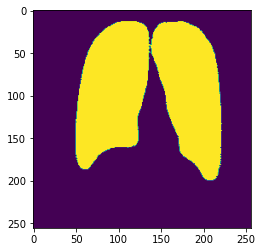

In [54]:
print("Generate masks for covid19")
pred_and_save_masks(BASE_COVID_DATA_PATH, BASE_COVID_MASKS_PATH)